# Case Study: Compositional Inference for a Drift Diffusion Model

Consider a decision task in which participants are presented with sequences of letters and asked
to differentiate between words and non-words (i.e., a lexical decision task). The Diffusion Decision Model (DDM;
e.g., Ratcliff et al., 2016) simulataneously models this binary decision and the response time via a continuous evidence
accumulation process: After an initial non-decision time t0, evidence accumulates following a noisy diffusion process
with a certain drift rate ν, starting from a point β, until one of two decision thresholds {0,α}corresponding to the two
choices is hit.

\begin{align*}
\mu_\nu \sim\mathcal{N}(0.5,0.3) \\
\mu_\alpha \sim\mathcal{N}(0,0.05) \\
\mu_{t_0}\sim \mathcal{N}(−1,0.3) \\
\log \sigma_\nu \sim\mathcal{N}(−1,1) \\
\log \sigma_\alpha \sim\mathcal{N}(−3,1) \\
\log \sigma_{t_0}\sim\mathcal{N}(−1,0.3) \\
\nu_j\sim\mathcal{N}(\mu_\nu,\sigma_\nu) \\
\log \alpha_j\sim\mathcal{N}(\mu_\alpha,\sigma_\alpha) \\
\log t_{0,j}\sim\mathcal{N}(\mu_{t_0} ,\sigma_{t_0} ) \\
\beta\sim\operatorname{Beta}(a=50,b=50) \\
y_j\sim \operatorname{DDM}(\nu_j,\alpha_j,t_{0,j},\beta)
\end{align*}

$\beta_\text{raw}$ is a transformed unbounded variable that is transformed to $\beta$ via the beta inverse CDF.

In [ ]:
import os
if "KERAS_BACKEND" not in os.environ:
    os.environ["KERAS_BACKEND"] = "torch"
else:
    print(f"Using '{os.environ['KERAS_BACKEND']}' backend")

import numpy as np
import matplotlib.pyplot as plt

import keras
import bayesflow as bf

from ddm_simulator import simulate_ddm, beta_from_normal

problem_name = "compositional_case_study"
storage = '' #f'plots/{problem_name}/'
n_jobs = 10 #int(os.environ.get('SLURM_CPUS_PER_TASK', 1))

In [151]:
param_names_global = ['mu_nu', 'mu_log_alpha', 'mu_log_t0',
                      'log_sigma_nu', 'log_sigma_log_alpha', 'log_sigma_log_t0',
                      'beta_raw']
pretty_param_names_global = [r'$\mu_\nu$', r'$\mu_{\log \alpha}$', r'$\mu_{\log t_0}$',
                              r'$\log \sigma_\nu$', r'$\log \sigma_{\log \alpha}$', r'$\log \sigma_{\log t_0}$',
                              r'$\beta$']
param_names_local = ['nu', 'alpha', 't0']
pretty_param_names_local = [r'$\nu_p$', r'$\alpha_p$', r'$t_{0,p}$']
pretty_param_names_local_log = [r'$\nu_p$', r'$\log\alpha_p$', r'$\log t_{0,p}$']
num_training_batches = 256
num_validation_sets = 300
batch_size = 128
epochs = 1000

In [ ]:
# ---------------------------
# Priors
# ---------------------------
n_trials = 30
def sample_priors(n_subjects=1):
    """
    Hierarchical draws as in your specification.
    Returns a dict with group params and per subject params.
    """
    # Group level
    mu_nu = np.random.normal(0.5, 0.3)
    mu_log_alpha = np.random.normal(0.0, 0.05)
    mu_log_t0 = np.random.normal(-1.0, 0.3)

    log_sigma_nu = np.random.normal(-1.0, 1.0)
    log_sigma_log_alpha = np.random.normal(-3.0, 1.0)
    log_sigma_log_t0 = np.random.normal(-1.0, 0.3)

    sigma_nu = np.exp(log_sigma_nu)
    sigma_log_alpha = np.exp(log_sigma_log_alpha)
    sigma_log_t0 = np.exp(log_sigma_log_t0)

    beta_raw = np.random.normal(0.0, 1.0)
    beta = beta_from_normal(beta_raw, a=50, b=50)

    # Subject level
    nu = np.random.normal(mu_nu, sigma_nu, size=n_subjects)
    log_alpha = np.random.normal(mu_log_alpha, sigma_log_alpha, size=n_subjects)
    log_t0 = np.random.normal(mu_log_t0, sigma_log_t0, size=n_subjects)
    alpha = np.exp(log_alpha)
    t0 = np.exp(log_t0)

    return {
        # group
        "mu_nu": mu_nu,
        "mu_log_alpha": mu_log_alpha,
        "mu_log_t0": mu_log_t0,
        "log_sigma_nu": log_sigma_nu,
        "log_sigma_log_alpha": log_sigma_log_alpha,
        "log_sigma_log_t0": log_sigma_log_t0,
        "beta_raw": beta_raw,
        "beta": beta,
        # subjects
        "nu": nu,
        "alpha": alpha,
        "t0": t0,
        # meta
        "n_subjects": n_subjects,
        "n_trials": n_trials,
    }


def score_log_norm(x, m, s):
    return -(x-m) / s**2

def prior_score(x: dict):
    mu_nu = x["mu_nu"]
    mu_log_alpha = x["mu_log_alpha"]
    mu_log_t0 = x["mu_log_t0"]
    log_sigma_nu = x["log_sigma_nu"]
    log_sigma_log_alpha = x["log_sigma_log_alpha"]
    log_sigma_log_t0 = x["log_sigma_log_t0"]
    beta_raw = x["beta_raw"]

    parts = {
        "mu_nu": score_log_norm(mu_nu, m=0.5, s=0.3),
        "mu_log_alpha": score_log_norm(mu_log_alpha, m=0.0, s=0.05),
        "mu_log_t0": score_log_norm(mu_log_t0, m=-1.0, s=0.3),
        "log_sigma_nu": score_log_norm(log_sigma_nu, m=-1.0, s=1.0),
        "log_sigma_log_alpha": score_log_norm(log_sigma_log_alpha, m=-3.0, s=1.0),
        "log_sigma_log_t0": score_log_norm(log_sigma_log_t0, m=-1.0, s=0.3),
        "beta_raw": score_log_norm(beta_raw, m=0.0, s=1.0),
    }
    return parts

simulator = bf.make_simulator([sample_priors, simulate_ddm])
print(simulator.sample(1)['sim_data'].shape)

In [ ]:
training_data = None #simulator.sample_parallel((num_training_batches * batch_size))
validation_data = simulator.sample_parallel(num_validation_sets)

In [ ]:
adapter = (
    bf.adapters.Adapter()
    .to_array()
    .convert_dtype("float64", "float32")
    .concatenate(param_names_global, into="inference_variables")
    .rename("sim_data", "summary_variables")
)

In [ ]:
# check how the distributions look like
test_params = adapter.forward(validation_data)['inference_variables']

n_rows = len(param_names_global) // 4
n_cols = int(np.ceil(len(param_names_global) / n_rows))
fig, ax = plt.subplots(n_rows, n_cols, figsize=(2*n_cols, 2*n_rows), layout='constrained')
ax = ax.flatten()
for i, name in enumerate(pretty_param_names_global):
    samples = test_params[:, i]
    ax[i].hist(samples, density=True)
    ax[i].set_title(name)
plt.show()

In [ ]:
# check how the data distribution looks like (disable nan_to_num in adapter to see nans)
test_data = adapter.forward(validation_data)['summary_variables']
n_features = test_data.shape[-1]

fig, ax = plt.subplots(nrows=2, ncols=int(np.ceil(n_features / 2)), figsize=(8, 4), layout='constrained')
ax = ax.flatten()
for i in range(n_features):
    ax[i].hist(test_data[..., i].flatten(), density=True)
plt.show()

print(test_data.shape)

In [ ]:
scores = prior_score(validation_data)

# check how the distributions look like
n_rows = len(param_names_global) // 4
n_cols = int(np.ceil(len(param_names_global) / n_rows))
fig, ax = plt.subplots(n_rows, n_cols, figsize=(2*n_cols, 2*n_rows), layout='constrained')
ax = ax.flatten()
for i, name in enumerate(param_names_global):
    ax[i].hist(scores[name], density=True)
    ax[i].set_title(r'$\nabla \log p($' + pretty_param_names_global[i] + '$)$')
plt.show()

# Non-Compositional inference

In [ ]:
workflow_global = bf.BasicWorkflow(
    adapter=adapter,
    summary_network=bf.networks.SetTransformer(summary_dim=16, dropout=0.1),
    inference_network=bf.networks.CompositionalDiffusionModel(),
)

In [ ]:
model_path = f'{storage}models/partial_pooling_global.keras'
if not os.path.exists(model_path):
    history = workflow_global.fit_offline(
        training_data,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=validation_data,
        verbose=2,
    )
    workflow_global.approximator.save(model_path)
else:
    workflow_global.approximator = keras.models.load_model(model_path)

In [ ]:
diagnostics_plots = workflow_global.plot_default_diagnostics(test_data=validation_data, num_samples=100,
                                                             calibration_ecdf_kwargs={"difference": True},
                                                             variable_names=pretty_param_names_global)
#for k in diagnostics_plots.keys():
#    diagnostics_plots[k].savefig(f"{storage}plots/partial_pooling_single_subject_{k}.png")

# Partial Pooling: Global Compositional inference

In [ ]:
test_data_comp_subjects = simulator.sample_parallel(100, n_subjects=30, n_trials=n_trials)
validation_data['sim_data'].shape, test_data_comp_subjects['sim_data'].shape

In [ ]:
num_samples = 100
test_posterior_comp_subjects = workflow_global.compositional_sample(
    num_samples=num_samples,
    conditions={'sim_data': test_data_comp_subjects['sim_data']},
    compute_prior_score=prior_score,
    #steps=300,
    #corrector_steps=2,
    compositional_bridge_d1=0.05,
    mini_batch_size=1
)
ps = test_posterior_comp_subjects.copy()
ps['beta'] = beta_from_normal(ps['beta_raw'], a=50, b=50)
ps.pop('beta_raw');

In [ ]:
fig = bf.diagnostics.recovery(
    estimates=ps,
    targets=test_data_comp_subjects,
    variable_names=pretty_param_names_global
)
fig.savefig(f"{storage}plots/partial_pooling_compositional_subjects_recovery.png")

fig = bf.diagnostics.calibration_ecdf(
    estimates=ps,
    targets=test_data_comp_subjects,
    difference=True,
    variable_names=pretty_param_names_global
)
# fig.savefig(f"{storage}plots/partial_pooling_compositional_subjects_calibration.png")

## Training a non-compositional local model

In [ ]:
adapter_subjects = (
    bf.adapters.Adapter()
    .to_array()
    .convert_dtype("float64", "float32")
    .log(["alpha", "t0"])  # log-transform alpha and t0 to make them unbounded
    .concatenate(param_names_local, into="inference_variables")
    .concatenate(param_names_global, into="inference_conditions")
    .rename("sim_data", "summary_variables")
)

In [ ]:
workflow_local = bf.BasicWorkflow(
    adapter=adapter_subjects,
    summary_network=bf.networks.SetTransformer(summary_dim=16, dropout=0.1),
    inference_network=bf.networks.FlowMatching(),
)

In [ ]:
model_path = f'{storage}models/partial_pooling_local.keras'
if not os.path.exists(model_path):
    history = workflow_local.fit_offline(
        training_data,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=validation_data,
        verbose=2,
    )
    workflow_local.approximator.save(model_path)
else:
    workflow_local.approximator = keras.models.load_model(model_path)

In [ ]:
diagnostics_plots = workflow_local.plot_default_diagnostics(test_data=validation_data, num_samples=100,
                                                             calibration_ecdf_kwargs={"difference": True},
                                                             variable_names=pretty_param_names_local)

In [ ]:
# one global sample per subject
subject_id = np.random.choice(test_data_comp_subjects['sim_data'].shape[1])
print(subject_id)
test_data_local_subject = {
    'sim_data': np.tile(test_data_comp_subjects['sim_data'][:, subject_id][..., None], num_samples).transpose((0,3,1,2)).reshape(-1, n_trials, 2),
    'mu_nu': test_posterior_comp_subjects['mu_nu'].reshape(-1, 1),
    'mu_log_alpha': test_posterior_comp_subjects['mu_log_alpha'].reshape(-1, 1),
    'mu_log_t0': test_posterior_comp_subjects['mu_log_t0'].reshape(-1, 1),
    'log_sigma_nu': test_posterior_comp_subjects['log_sigma_nu'].reshape(-1, 1),
    'log_sigma_log_alpha': test_posterior_comp_subjects['log_sigma_log_alpha'].reshape(-1, 1),
    'log_sigma_log_t0': test_posterior_comp_subjects['log_sigma_log_t0'].reshape(-1, 1),
    'beta_raw': test_posterior_comp_subjects['beta_raw'].reshape(-1, 1),

    # true local params for evaluation
    'nu': test_data_comp_subjects['nu'][:, subject_id].reshape(-1, 1),
    'alpha': test_data_comp_subjects['alpha'][:, subject_id].reshape(-1, 1),
    't0': test_data_comp_subjects['t0'][:, subject_id].reshape(-1, 1),
}

test_local_samples_subject = workflow_local.sample(conditions=test_data_local_subject, num_samples=1)
for key in test_local_samples_subject.keys():
    test_local_samples_subject[key] = test_local_samples_subject[key].reshape(*test_posterior_comp_subjects['mu_nu'].shape)

In [139]:
import numpy as np

n_subjects = test_data_comp_subjects['sim_data'].shape[1]

all_samples = None
combined = {}

# preallocate containers per key
keys_to_collect = None

for s in range(n_subjects):
    print(s)
    test_data_local_subject = {
        'sim_data': np.tile(
            test_data_comp_subjects['sim_data'][:, s][..., None],
            num_samples
        ).transpose((0, 3, 1, 2)).reshape(-1, n_trials, 2),

        'mu_nu': test_posterior_comp_subjects['mu_nu'].reshape(-1, 1),
        'mu_log_alpha': test_posterior_comp_subjects['mu_log_alpha'].reshape(-1, 1),
        'mu_log_t0': test_posterior_comp_subjects['mu_log_t0'].reshape(-1, 1),
        'log_sigma_nu': test_posterior_comp_subjects['log_sigma_nu'].reshape(-1, 1),
        'log_sigma_log_alpha': test_posterior_comp_subjects['log_sigma_log_alpha'].reshape(-1, 1),
        'log_sigma_log_t0': test_posterior_comp_subjects['log_sigma_log_t0'].reshape(-1, 1),
        'beta_raw': test_posterior_comp_subjects['beta_raw'].reshape(-1, 1),

        # true local params for evaluation
        #'nu':   test_data_comp_subjects['nu'][:, s].reshape(-1, 1),
        #'alpha': test_data_comp_subjects['alpha'][:, s].reshape(-1, 1),
        #'t0':   test_data_comp_subjects['t0'][:, s].reshape(-1, 1),
    }

    samples_s = workflow_local.sample(conditions=test_data_local_subject, num_samples=1)

    # on first pass create storage
    if keys_to_collect is None:
        keys_to_collect = list(samples_s.keys())
        for k in keys_to_collect:
            combined[k] = []

    # match your original reshape
    for k in keys_to_collect:
        combined[k].append(
            samples_s[k].reshape(*test_posterior_comp_subjects['mu_nu'].shape)
        )

test_combined = {}
for p in param_names_local:
    combined[k] = np.array(combined[k]).transpose(1,0,2,3)
    combined[k] = combined[k].reshape(-1, num_samples, 1)
    test_combined[p] = test_data_comp_subjects[p].reshape(-1, 1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [148]:
test_combined['log_alpha'] = np.log(test_combined['alpha'])
test_combined['log_t0'] = np.log(test_combined['t0'])
combined['log_alpha'] = np.log(combined['alpha'])
combined['log_t0'] = np.log(combined['t0'])

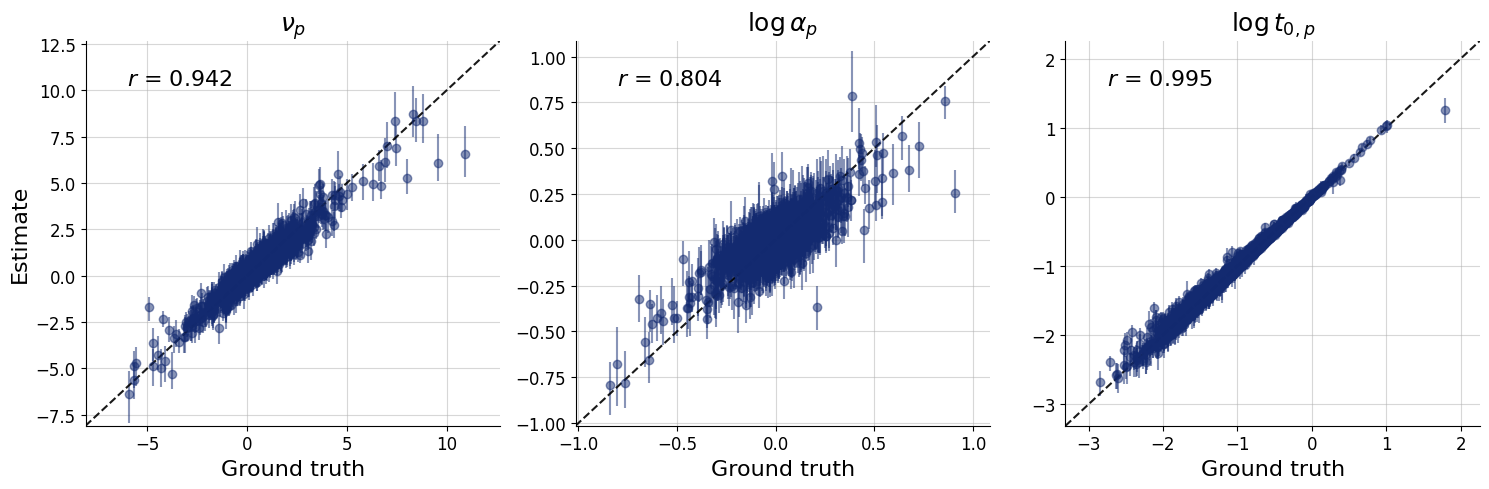

In [153]:
fig = bf.diagnostics.recovery(
    estimates=combined, #test_local_samples_subject,
    targets=test_combined, #test_data_local_subject,
    variable_names=pretty_param_names_local_log,
    variable_keys=['nu', 'log_alpha', 'log_t0']
)
fig.savefig(f"{storage}plots/partial_pooling_local_subject_recovery.png")